In [1]:
import numpy as np
from scipy.stats import rankdata

import time

from collections import OrderedDict

from sklearn.datasets import fetch_covtype
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
# NOTE The add_indicator_feature is not in sklearn 0.18.0 This is a patched version for benchmarking...
from sklearn.preprocessing import Imputer
from sklearn.model_selection import cross_val_score

from scipy.io.arff import loadarff as scipy_loadarff
from arff import load as liac_loadarff

# https://github.com/pyarff/pyarff
# NOTE pyarff is very much experimental and is not finished fully yet
# scipy arff is a bit slow but doesn't encode categories.
# LIAC is another arff reader that works on sparse too
import pyarff

from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline
import matplotlib.image as img
import matplotlib.pyplot as plt

import pygraphviz as pgv

from sklearn.tree import export_graphviz
from io import BytesIO

def get_graph(dtc, n_classes, feat_names=None, size=[7, 7]):
    # Get the dot graph of our decision tree
    tree_dot = export_graphviz(
        dtc, out_file=None, feature_names=feat_names, rounded=True, filled=True,
        special_characters=True, class_names=list(map(str, range(n_classes))), max_depth=10)
    # Convert this dot graph into an image
    g = pgv.AGraph(tree_dot)
    g.layout('dot')
    g.draw(path='temp.png')
    # Plot it
    plt.figure().set_size_inches(*size)
    plt.axis('off')
    plt.imshow(img.imread(fname='temp.png'))
    plt.show()

rng = np.random.RandomState(0)

all_datasets = OrderedDict()

#### Basic Demo of DecisionTreeClassifier handling missing values natively

In [2]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(missing_values='NaN')

# Class 0 if missing or <= 3.5
# Class 1 if not missing and > 3.5
dtc.fit([[np.nan,], [np.nan,], [np.nan,], [1,], [2,], [3,], [4,], [5,], [6,]],
        [0, 0, 0, 0, 0, 0, 1, 1, 1])
print(dtc.predict([[np.nan], [0,], [7,], [3.6,]]))

[0 0 1 1]


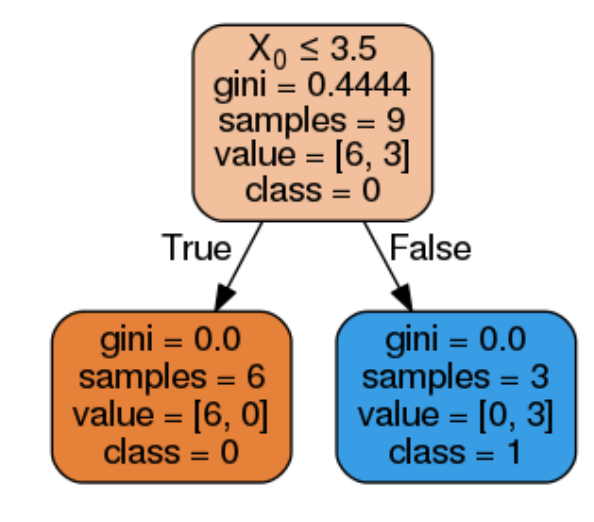

In [3]:
g = get_graph(dtc, n_classes=2)

#### Let's do some benchmarks on datasets

In [4]:
# Anneal dataset - http://www.openml.org/d/2

meta1, data1 = pyarff.load_arff_dataset('/home/raghavrv/code/datasets/arff/anneal.arff')
data1 = data1[:-1]  # The last one seems to have a wrong class label. Check pyarff.
X, y = data1[:, :-1], data1[:, -1]
all_datasets['anneal'] = (X, y)

In [5]:
# KDDCUP09_churn - http://www.openml.org/d/1112

# start = time.time()
# data = scpy_arff_load('/home/raghavrv/code/datasets/arff/KDDCup09_churn.arff')[0]
# print("KDDCUP09_churn ARFF dataset loaded in %0.8fs" % (time.time() - start))
# X = np.array([np.array(list(data_i))[:190] for data_i in data]).astype(float)
# y = np.array([data_i[-1] for data_i in data]).astype(int)

meta2, data2 = pyarff.load_arff_dataset('/home/raghavrv/code/datasets/arff/KDDCup09_churn.arff',
                                        encode_nominals=True)
X, y = data2[:, :-1], data2[:, -1]
all_datasets['KDDCUP09_churn'] = (X, y)

In [6]:
# KDDCUP09_appetency - http://www.openml.org/d/1111

meta3, data3 = pyarff.load_arff_dataset('/home/raghavrv/code/datasets/arff/KDDCup09_appetency.arff',
                                        encode_nominals=True)
X, y = data3[:, :-1], data3[:, -1]
all_datasets['KDDCUP09_appetency'] = (X, y)

In [7]:
# KDDCUP09_upselling - http://www.openml.org/d/1114

meta4, data4 = pyarff.load_arff_dataset('/home/raghavrv/code/datasets/arff/KDDCup09_upselling.arff',
                                        encode_nominals=True)
X, y = data4[:, :-1], data4[:, -1]
all_datasets['KDDCUP09_upselling'] = (X, y)

In [8]:
# Loan Default - http://www.openml.org/d/6331

meta5, data5 = pyarff.load_arff_dataset('/home/raghavrv/code/datasets/arff/loan_default.arff',
                                        encode_nominals=True)

X, y = data5[:, :-1].astype(float), data5[:, -1].astype(int)
all_datasets['loan_default'] = (X, y) # --> This takes a long time to train

In [9]:
# Soy Bean dataset - http://www.openml.org/d/42

meta6, data6 = pyarff.load_arff_dataset('/home/raghavrv/code/datasets/arff/soybean.arff',
                                        encode_nominals=True)
X, y = data6[:, :-1].astype(float), data6[:, -1].astype(int)
all_datasets['soy_bean'] = (X, y)

In [10]:
# Adult Census dataset - https://archive.ics.uci.edu/ml/datasets/Adult

meta7, data7 = pyarff.load_arff_dataset('/home/raghavrv/code/datasets/arff/adult-census.arff',
                                        encode_nominals=True)
X, y = data7[:, :-1].astype(float), data7[:, -1].astype(int)
all_datasets['adult_census'] = (X, y)

In [11]:
# Lymphoma 11 classes - http://www.openml.org/d/1109

meta8, data8 = pyarff.load_arff_dataset('/home/raghavrv/code/datasets/arff/lymphoma_11classes.arff',
                                        encode_nominals=True)
X, y = data8[:, :-1].astype(float), data8[:, -1].astype(int)
all_datasets['lymphoma_11classes'] = (X, y)

In [12]:
# KDD98 - http://www.openml.org/d/23513

meta9, data9 = pyarff.load_arff_dataset('/home/raghavrv/code/datasets/arff/kdd98_data.arff',
                                        encode_nominals=True)
target_index = meta9['attribute_names_in_order'].index(b'TARGET_B')
X = np.hstack([data9[:, :target_index], data9[:, target_index+1:]]).astype(float)
y = data9[:, target_index].astype(int)
all_datasets['kdd98'] = (X, y)

In [13]:
# Colleges US News binarized - http://www.openml.org/d/930

# data10_ = scipy_loadarff('/home/raghavrv/code/datasets/arff/colleges_usnews.arff')[0]
# X_ = np.array([list(data_i) for data_i in data10_])[:-1]
# y_ = np.array([data_i[-1] for data_i in data10_])[:-1]

meta10, data10 = pyarff.load_arff_dataset('/home/raghavrv/code/datasets/arff/colleges_usnews.arff',
                                          encode_nominals=True)
data10 = data10[:-1]  # The last one seems to have a wrong class label. Bug in pyarff.
X, y = data10[:, :-1].astype(float), data10[:, -1].astype(int)
all_datasets['colleges_usnews'] = (X, y)

In [14]:
import warnings
warnings.filterwarnings("ignore")

n_jobs = 16
n_estimators = 100

for name, (X, y) in all_datasets.items():
    n_samples = X.shape[0]
    n_features = X.shape[1]
    
    benchmarks = []  # Tuple of (<technique>, mean cross val score, total fit time)

    missing_mask = np.isnan(X)
    missing_samples, missing_features = np.where(missing_mask)
    print("Dataset %s with %d samples and %d features and %0.4f%% values missing" 
          % (name, n_samples, n_features, 100. * (np.sum(missing_mask) / (n_samples * n_features))))
    print("===============================================================================================\n")

    # 1) Estimate score with RFC natively handling missing values
    estimator = RandomForestClassifier(random_state=0, n_jobs=n_jobs,
                                       missing_values="NaN", n_estimators=n_estimators)
    score = cross_val_score(estimator, X, y).mean()
    start = time.time()
    estimator.fit(X, y)
    benchmarks.append(('Random Forest natively handling it', score, time.time() - start))
    
    
    
    
    
    # 2) Estimate score after imputation of missing values without indicator features
    estimator = Pipeline([("Impute", Imputer(missing_values="NaN", strategy="mean",
                                             add_indicator_features=False, axis=0)),
                          ("rf", RandomForestClassifier(random_state=0,
                                                       n_jobs=n_jobs, n_estimators=n_estimators))])
    score = cross_val_score(estimator, X, y).mean()
    
    start = time.time()
    estimator.fit(X, y)
    benchmarks.append(('imputation of the missing values', score, time.time() - start))
    
    
    
    # 3) Estimate score after imputation of the missing values with indicator matrix
    estimator = Pipeline([("Impute", Imputer(missing_values="NaN", strategy="mean",
                                             add_indicator_features=True, axis=0)),
                          ("rf", RandomForestClassifier(random_state=0,
                                                       n_jobs=n_jobs, n_estimators=n_estimators))])
    score = cross_val_score(estimator, X, y).mean()
    start = time.time()
    estimator.fit(X, y)
    benchmarks.append(('imputation of the missing values w/indicator features', score, time.time() - start))

    names, scores, times = list(zip(*benchmarks))
   
    ranks_score = rankdata(-np.array(scores), method='min')
    ranks_fit_time = rankdata(times, method='min')

    for i, benchmark in enumerate(benchmarks):
        print("%s Got a score of %0.8f [%s] with %s (Train time %0.2fs [%s] %s)"
              % ("*" if ranks_score[i] == 1 else " ",
                 benchmark[1], ranks_score[i], benchmark[0],
                 benchmark[2], ranks_fit_time[i],
                 "*" if ranks_fit_time[i] == 1 else " "))
        
    start = time.time()
    estimator.fit(X, y)
    print()

Dataset anneal with 897 samples and 38 features and 64.9856% values missing

  Got a score of 0.99331104 [2] with Random Forest natively handling it (Train time 0.19s [3]  )
* Got a score of 0.99442586 [1] with imputation of the missing values (Train time 0.17s [1] *)
  Got a score of 0.99331104 [2] with imputation of the missing values w/indicator features (Train time 0.19s [2]  )

Dataset KDDCUP09_churn with 50000 samples and 230 features and 69.7752% values missing

  Got a score of 0.91943971 [2] with Random Forest natively handling it (Train time 5.01s [2]  )
  Got a score of 0.89939891 [3] with imputation of the missing values (Train time 4.63s [1] *)
* Got a score of 0.91963973 [1] with imputation of the missing values w/indicator features (Train time 5.06s [3]  )

Dataset KDDCUP09_appetency with 50000 samples and 230 features and 69.7752% values missing

* Got a score of 0.98220000 [1] with Random Forest natively handling it (Train time 4.62s [3]  )
* Got a score of 0.98220000 

#### For the 10 tested datasets

##### * RF with missing values handled natively ranks 1st - 4 / 10 times, 2nd - 5 / 10 times and 3rd Just once.
##### * Imputation with missingness indicator features added ranks 1st - 4 / 10 times, 2nd - Once and 3rd - 3 / 10 times
##### * Simple imputation with no additional indicator features added ranks 1st - 2 / 10 times, 2nd - 5 / 10 times and 3rd 3 / 10 times.